# Altair interaction examples 

Below examples of interactive elements to common plots we make in the Bloom lab. 

I am using the plotting package [`altair`](https://altair-viz.github.io/index.html), which is a `python` wrapper for [`vega`](https://vega.github.io/vega/). 
There are a lot of great [plot examples](https://altair-viz.github.io/gallery/index.html) on the [`altair`](https://altair-viz.github.io/index.html) website.

SKH 20190602

## notebook setup

In [1]:
import warnings
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
warnings.filterwarnings('ignore')

## Tooltips

Tooltips allow you to reveal information only by hovering over a piece of data. 
My professor calls this "details on demand." 
This helps to de-clutter plots because encodings which were reserved for these pieces of information can be eliminated. 
I realized I sometimes use colors or facets in order to communicate very specific pieces of information which are better reported by a single number. 

### correlation plot

In [2]:
df = []
for rep in [1, 3]:
    temp = pd.read_csv(f"data/WSN_rep{rep}.csv")
    temp = pd.melt(temp, id_vars="site", var_name="AA", value_name="pref")
    temp["rep"] = f"rep_{rep}"
    df.append(temp)
df = pd.concat(df)
df = pd.pivot_table(df, values='pref', index=['site', 'AA'], columns=['rep']).reset_index()
df.head()

rep,site,AA,rep_1,rep_3
0,2,A,0.010058,0.011541
1,2,C,0.088480,0.165108
2,2,D,0.036346,0.001988
3,2,E,0.016338,0.012686
4,2,F,0.013438,0.071712


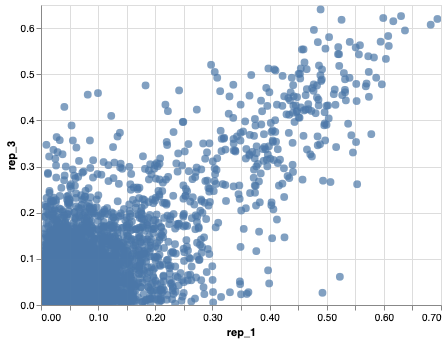

In [3]:
(alt.Chart(df)
 .mark_circle(size=60)
 .encode(
    x='rep_1',
    y='rep_3',
    tooltip=['site']
).interactive())

### neut curve

In [4]:
df = pd.read_csv("data/neut.csv")
df.head()

,ab_conc,mutation,rep,value
0,120.00,WT,1,98.83
1,40.00,WT,1,97.42
2,13.33,WT,1,97.13
3,4.44,WT,1,96.55
4,1.48,WT,1,96.01


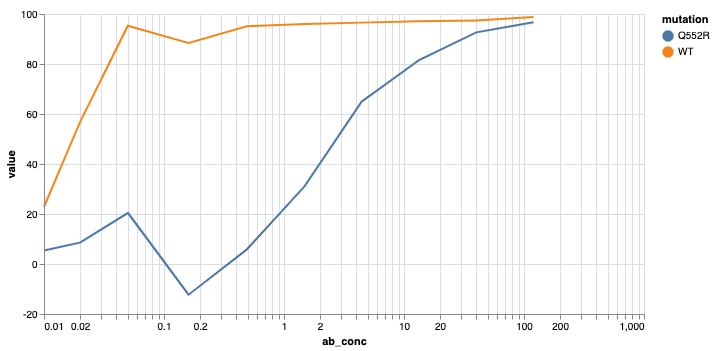

In [5]:
# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['ab_conc'], empty='none')

# The basic line
line = alt.Chart(df).mark_line().encode(
    alt.X('ab_conc', scale=alt.Scale(type='log')),
    y='value:Q',
    color='mutation:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(df).mark_point().encode(
    x='ab_conc:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'ab_conc:Q', alt.value(' ')),
)

# Draw a rule at the location of the selection
rules = alt.Chart(df).mark_rule(color='gray').encode(
    x='ab_conc:Q',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=600, height=300
)

Notice that it only shows the points that we actually measure - it snaps to the nearest point

## Filtering

A large class of interactions are filtering interactions. 
These allow the user to change what information is displayed on demand. 
You can filter which variable is shown or the range of the data that is shown. 
You can also filter plot based on a selection on another plot. 

## MAP line plot

In [6]:
df = pd.read_csv("data/map.csv")
df = pd.melt(df, id_vars="site", var_name="metric", value_name="value")
df.head()

,site,metric,value
0,1,abs_diffsel,3.549170
1,2,abs_diffsel,3.533695
2,3,abs_diffsel,3.244136
3,4,abs_diffsel,2.092767
4,5,abs_diffsel,2.638672


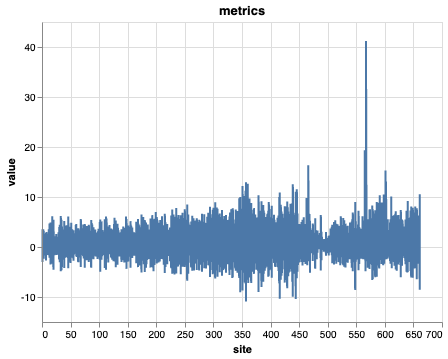

In [7]:
metrics = list(df["metric"].unique())
base = alt.Chart(df).mark_line().encode(
    x='site',
    y='value:Q'
)

# radio buttons for metrics 
metric_buttons = alt.binding_radio(options=metrics)
metric_select = alt.selection_single(fields=['metric'], bind=metric_buttons, name="_")
base = base.add_selection(
    metric_select
).transform_filter(
    metric_select
).properties(title="metrics")

base

## correlation plot*s*

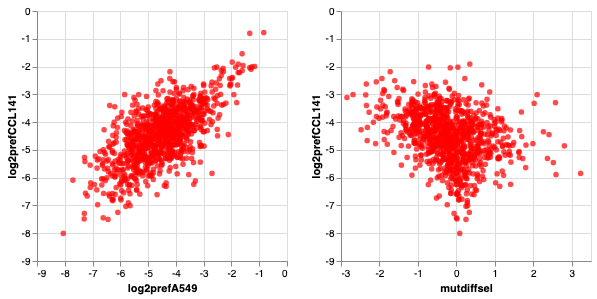

In [8]:
df = pd.read_csv("data/pb2.csv").head(n=1000)

brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(df).mark_circle().encode(
    y='log2prefCCL141',
    color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray')),
).add_selection(
    brush
).properties(
    width=250,
    height=250
)

base.encode(x='log2prefA549') | base.encode(x='mutdiffsel')